In [1]:
from base64 import decodebytes
from skimage.io import imread
from io import BytesIO
from skimage.color import rgba2rgb
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import *
from tensorflow.keras import Model
from tensorflow.keras.losses import CategoricalCrossentropy
import numpy as np
from gramex.data import filter as gfilter
from h5py import File
from tqdm import tqdm
from matplotlib import pyplot as plt
from chart_annotation import plot_history
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [2]:
df = gfilter('sqlite:///data/charts.db', table='charts')

In [22]:
to_keep = df['validated_label'].value_counts()[df['validated_label'].value_counts() > 21].index
df = df[df['validated_label'].isin(to_keep)]
df.head()

label validated_label  \
6            Map             map   
8   bubble chart     scatterplot   
12      barchart        barchart   
13           Map             map   
16   scatterplot     scatterplot   

                                                image  chart_id  is_validated  
6   data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...        14             1  
8   data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...        16             1  
12  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...        20             1  
13  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...        21             1  
16  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...        24             1

In [38]:
X = np.zeros((df.shape[0], 224, 224, 3))

In [39]:
for i, (_, row) in tqdm(enumerate(df.iterrows()), total=df.shape[0]):
    imgdata = row['image'].split(',')[-1]
    bytedata = decodebytes(imgdata.encode())
    image = imread(BytesIO(bytedata))
    image = rgba2rgb(image)
    image = resize(image, (224, 224), preserve_range=True)
    X[i] = image

100%|██████████| 170/170 [00:06<00:00, 25.04it/s]


In [40]:
ix = np.random.randint(0, df.shape[0], size=(16,))

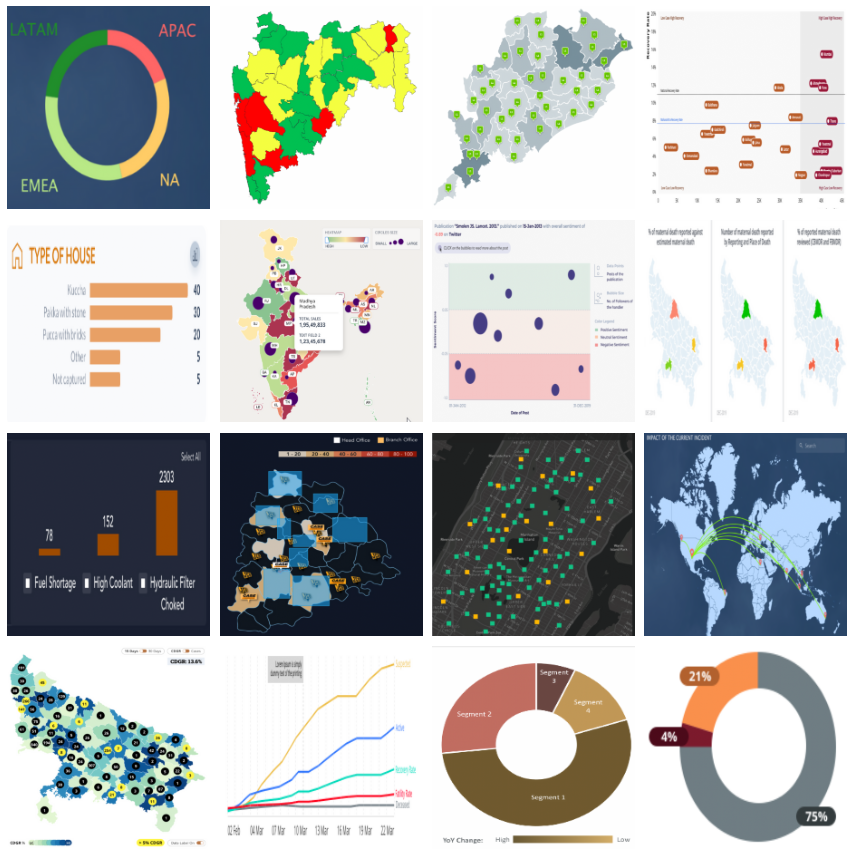

In [41]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))

for i in range(4):
    for j in range(4):
        c = i * 4 + j
        ax[i, j].imshow(X[ix[c]])
        ax[i, j].axis('off')
plt.tight_layout()

In [42]:
lenc = LabelEncoder()
y = lenc.fit_transform(df['validated_label'])

In [43]:
model = VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

In [44]:
model.trainable = False
ip_layer = layers.Input(shape=(224, 224, 3))
x = model(ip_layer, training=False)
x = layers.Dense(df['validated_label'].nunique())(x)
outer = Model(ip_layer, x)

outer.compile(optimizer=Adam(lr=0.01),
              loss=CategoricalCrossentropy(from_logits=True), metrics=['categorical_accuracy'])

In [45]:
y = to_categorical(y)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, stratify=np.argmax(y, axis=1))

In [46]:
datagen = ImageDataGenerator(
    horizontal_flip=True, zoom_range=0.5)
datagen.fit(xtrain)
history = outer.fit(
    datagen.flow(xtrain, ytrain, batch_size=32),
    steps_per_epoch=len(xtrain) / 32,
    epochs=1000,
    validation_data=(xtest, ytest),
    callbacks=[EarlyStopping('val_loss', min_delta=0.01, patience=30, restore_best_weights=True)]
)

Epoch 1/1000
4/3 [=================================] - 2s 413ms/step - loss: 1.5981 - categorical_accuracy: 0.3186 - val_loss: 1.5837 - val_categorical_accuracy: 0.3684
Epoch 2/1000
4/3 [=================================] - 1s 354ms/step - loss: 1.5772 - categorical_accuracy: 0.3717 - val_loss: 1.5628 - val_categorical_accuracy: 0.3684
Epoch 3/1000
4/3 [=================================] - 1s 347ms/step - loss: 1.5557 - categorical_accuracy: 0.3717 - val_loss: 1.5458 - val_categorical_accuracy: 0.3684
Epoch 4/1000
4/3 [=================================] - 2s 387ms/step - loss: 1.5401 - categorical_accuracy: 0.3717 - val_loss: 1.5315 - val_categorical_accuracy: 0.3684
Epoch 5/1000
4/3 [=================================] - 1s 344ms/step - loss: 1.5279 - categorical_accuracy: 0.3717 - val_loss: 1.5202 - val_categorical_accuracy: 0.3684
Epoch 6/1000
4/3 [=================================] - 1s 222ms/step - loss: 1.5160 - categorical_accuracy: 0.3717 - val_loss: 1.5116 - val_categorical_acc

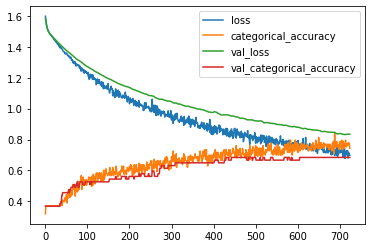

In [47]:
plot_history(history)

In [48]:
ix

array([ 59, 132, 154, 134, 122,   7, 140, 106, 105,  56,  64,  57, 157,
       133,  96, 153])

In [51]:
preds = outer.predict(X[ix]).argmax(axis=1)

In [52]:
preds

array([2, 2, 2, 4, 0, 2, 0, 0, 0, 2, 2, 2, 2, 3, 1, 1])

In [54]:
pred_labels = lenc.inverse_transform(preds)

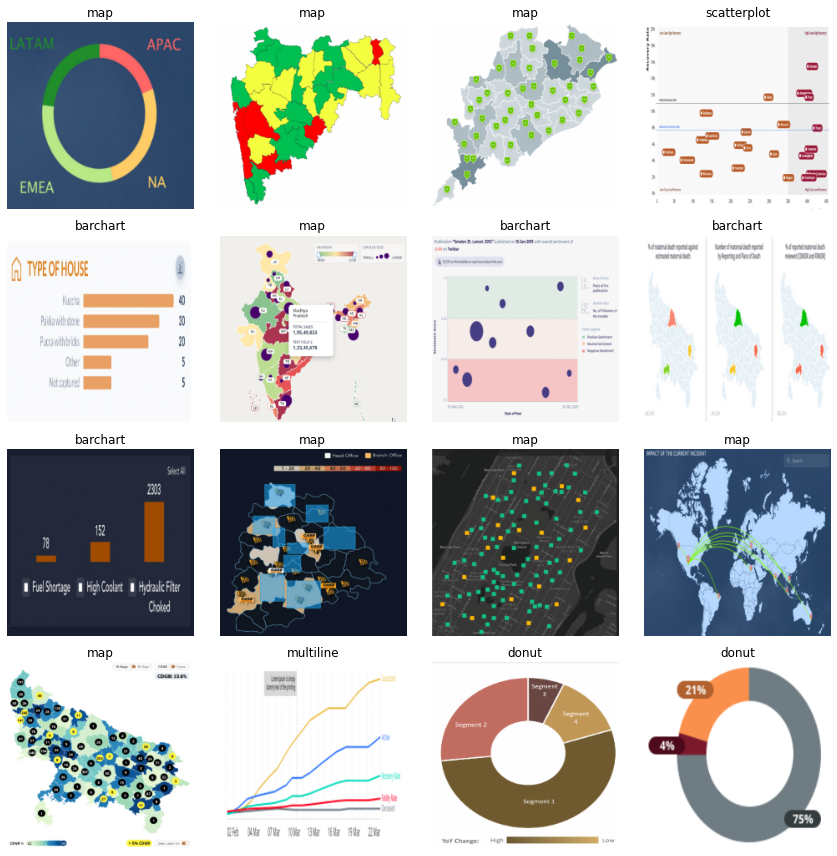

In [55]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))

for i in range(4):
    for j in range(4):
        c = i * 4 + j
        ax[i, j].imshow(X[ix[c]])
        ax[i, j].axis('off')
        ax[i, j].set_title(pred_labels[c])
plt.tight_layout()

In [61]:
un_labels = lenc.inverse_transform(np.unique(np.argmax(y, axis=1)))

In [63]:
df[df['validated_label'].isin(un_labels)]['validated_label'].value_counts()

map            63
barchart       37
donut          25
multiline      23
scatterplot    22
Name: validated_label, dtype: int64

In [64]:
X.shape

(170, 224, 224, 3)

In [91]:
print(lenc.classes_)
lenc.transform(['multiline'])

['barchart' 'donut' 'map' 'multiline' 'scatterplot']


array([3])

In [96]:
scatterX = X[y[:, 4] == 1]

In [97]:
scatterX.shape

(22, 224, 224, 3)

In [84]:
pred = outer.predict(barchartX).argmax(axis=1)
pred_labels = lenc.inverse_transform(pred)
def draw_grid(data, labels, size=6, figsize=(16, 16)):
    nrows = ncols = size
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for i in range(size):
        for j in range(size):
            c = i * size + j
            try:
                ax[i, j].imshow(data[c])
                ax[i, j].axis('off')
                ax[i, j].set_title(labels[c])
            except IndexError:
                pass
    plt.tight_layout()

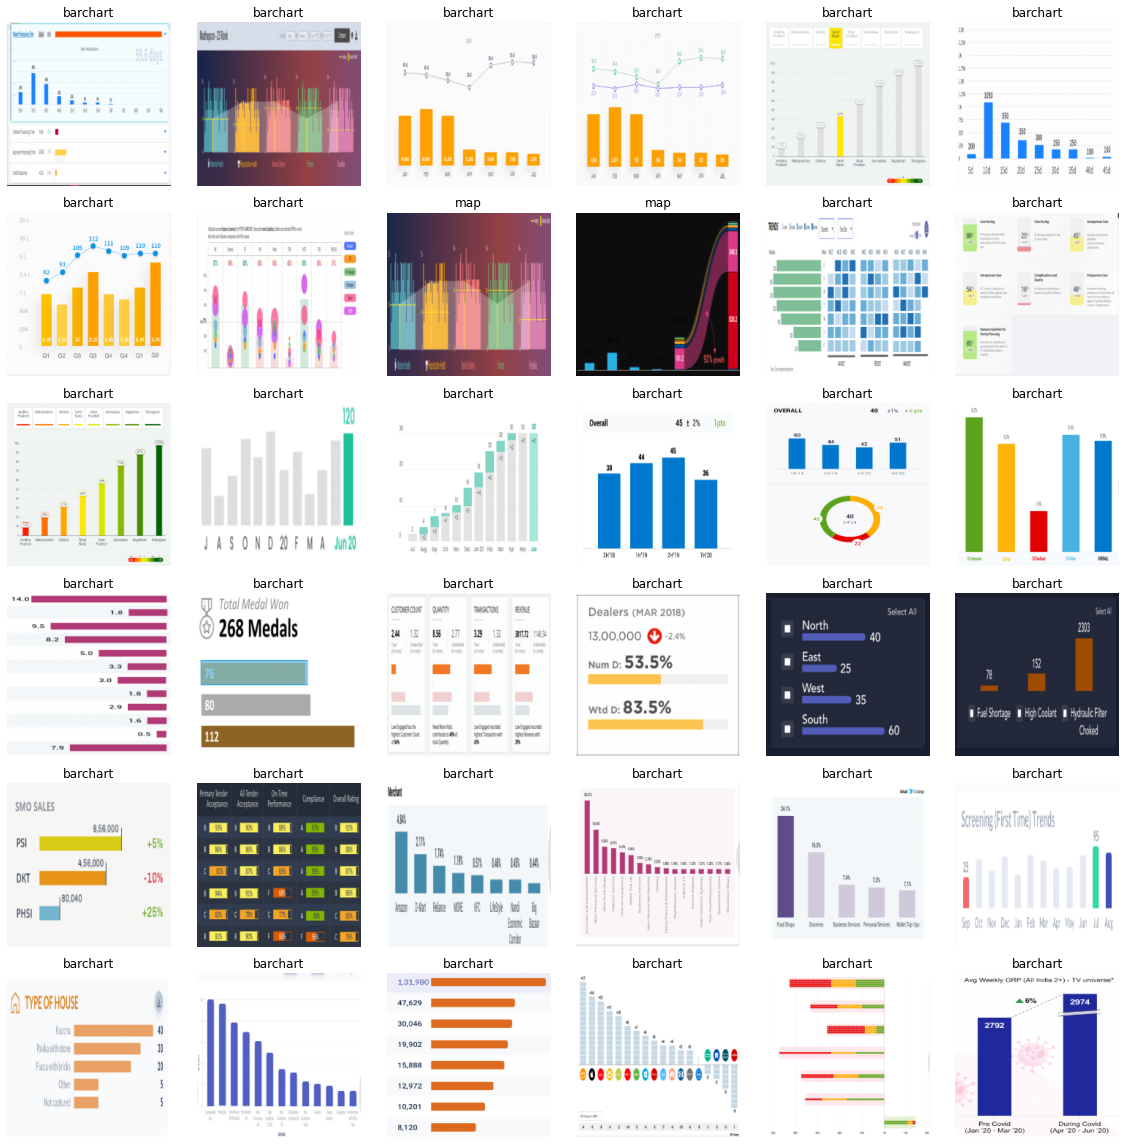

In [85]:
draw_grid(barchartX, pred_labels)

In [88]:
pred = outer.predict(donutX).argmax(axis=1)
pred_labels = lenc.inverse_transform(pred)

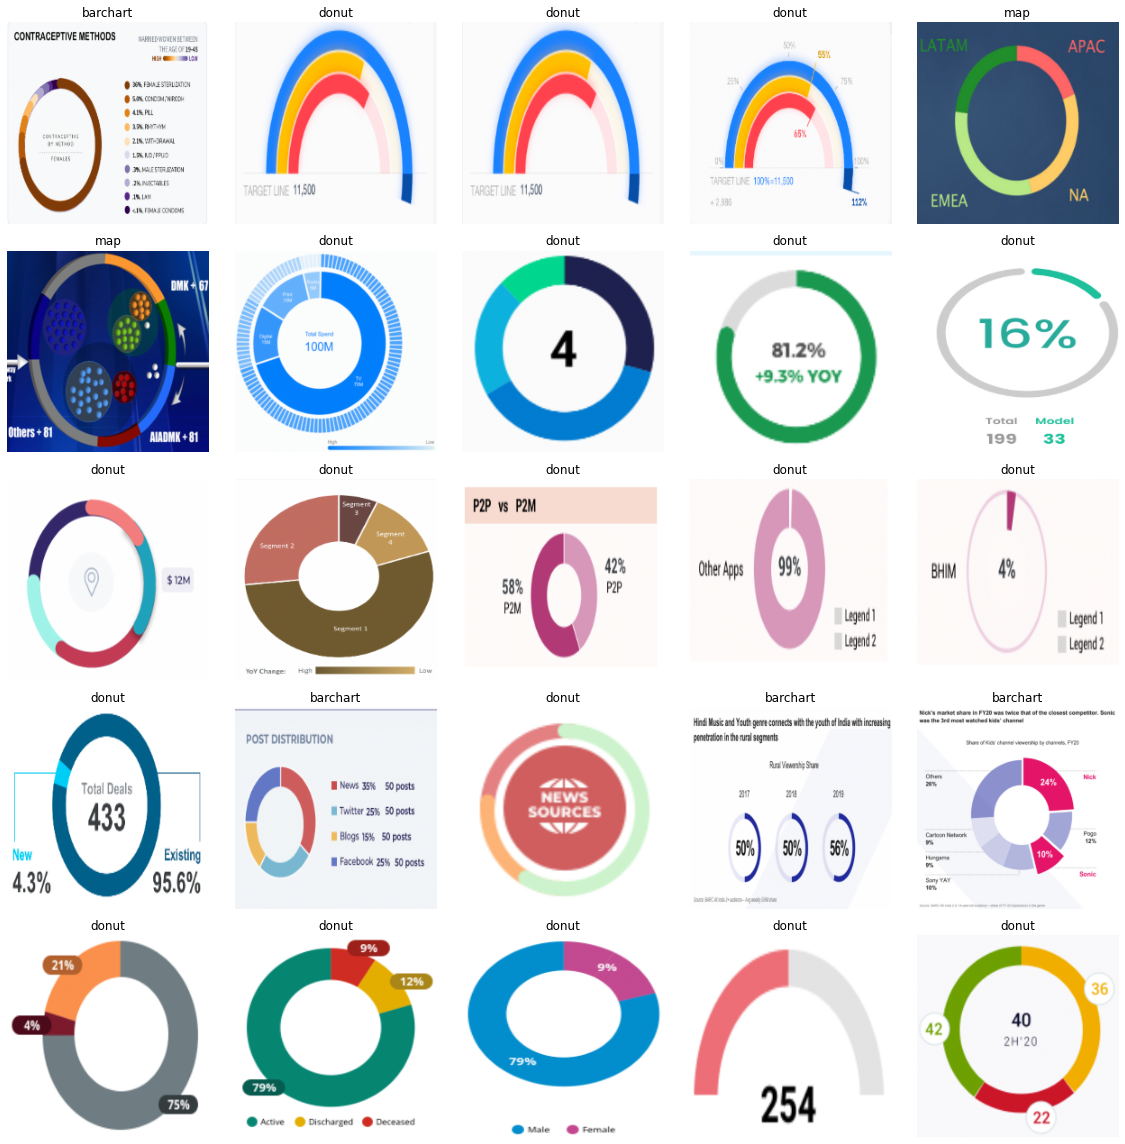

In [90]:
draw_grid(donutX, pred_labels, size=5)

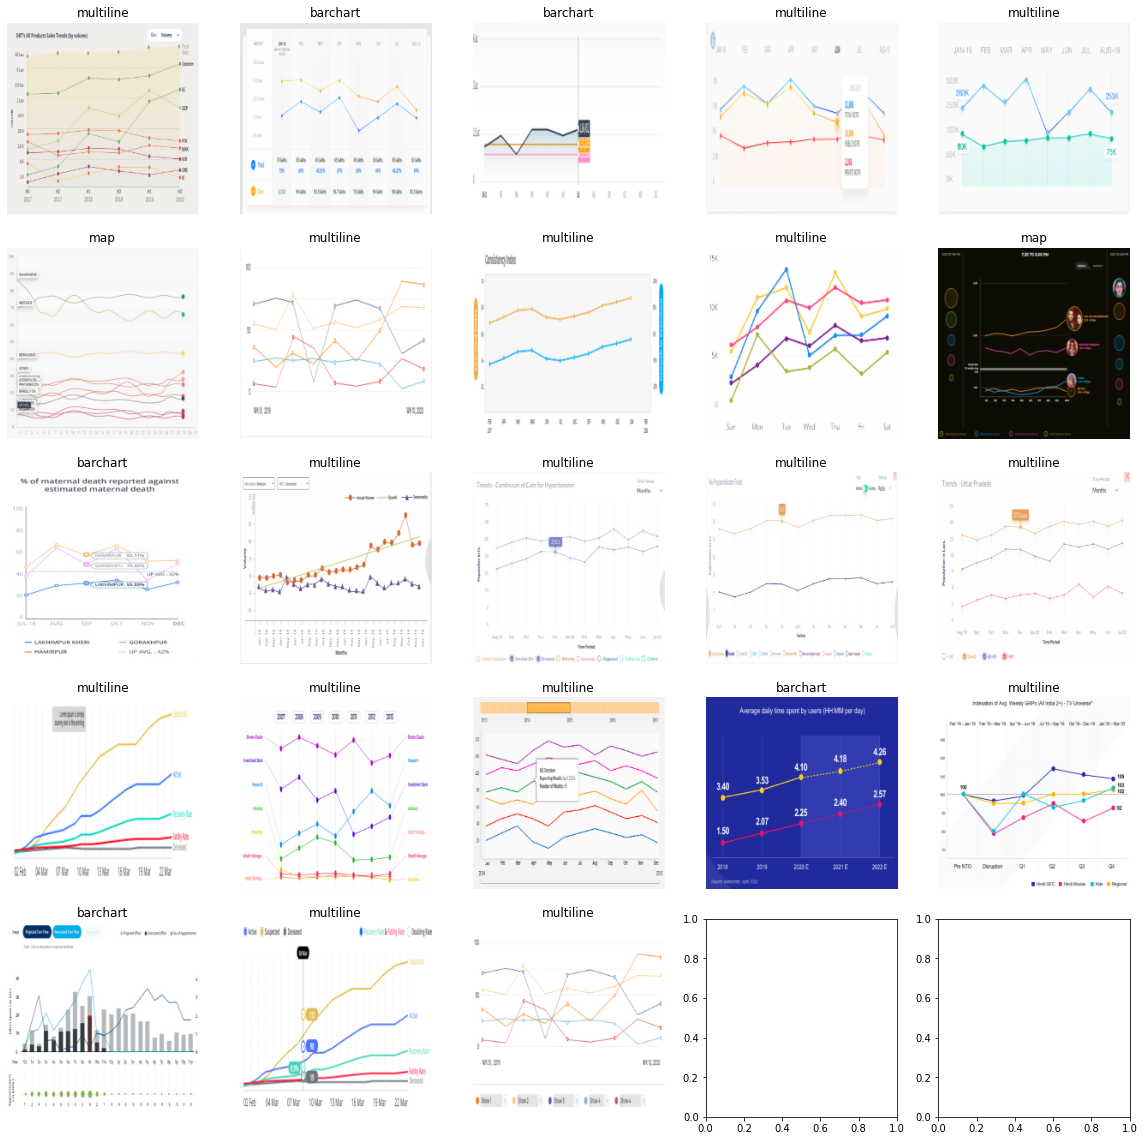

In [95]:
pred = outer.predict(multilineX).argmax(axis=1)
pred_labels = lenc.inverse_transform(pred)
draw_grid(multilineX, pred_labels, size=5)

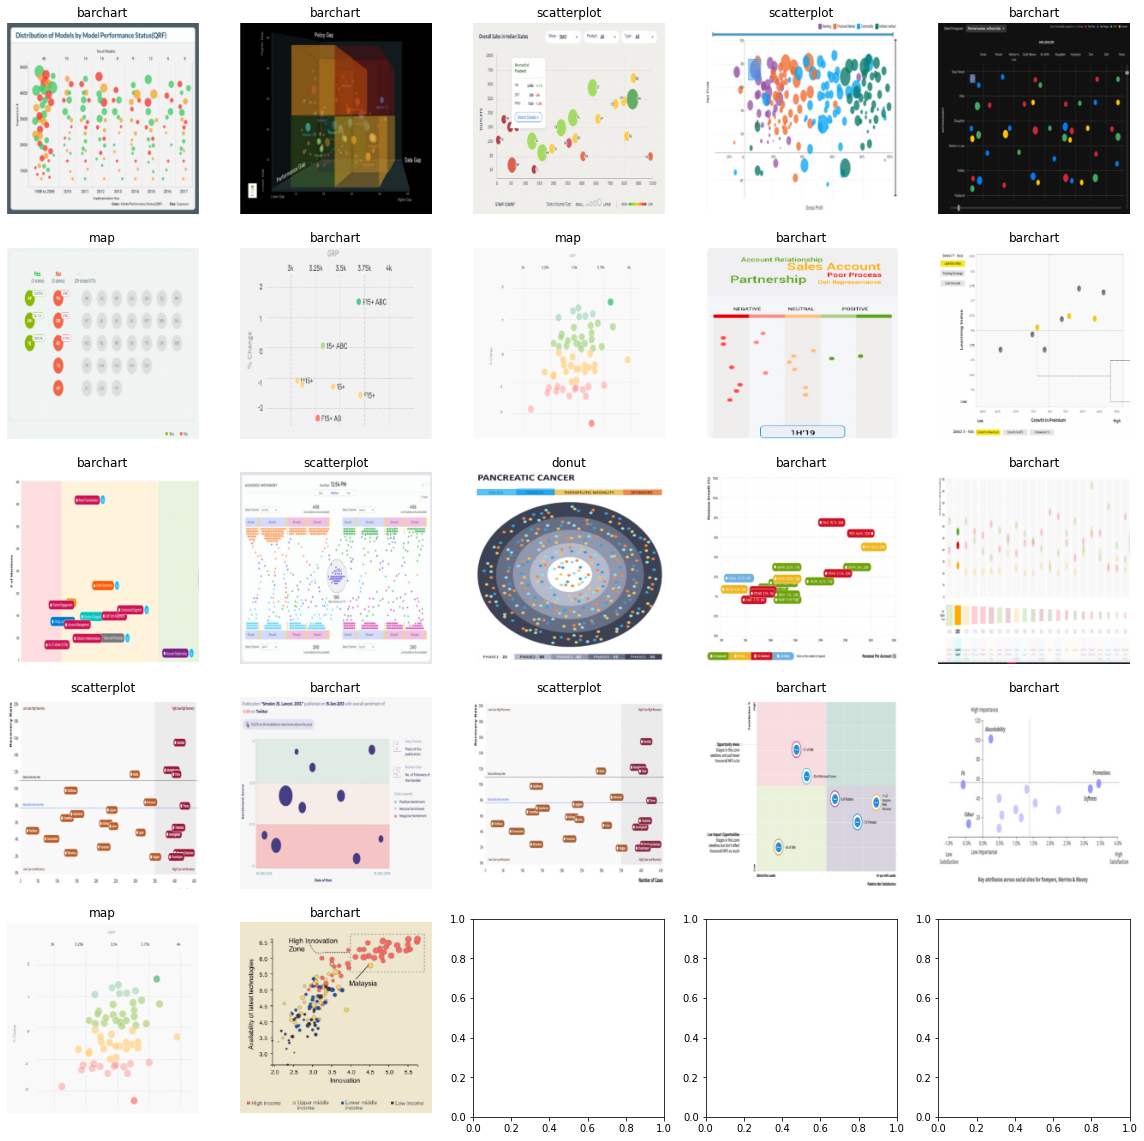

In [98]:
pred = outer.predict(scatterX).argmax(axis=1)
pred_labels = lenc.inverse_transform(pred)
draw_grid(scatterX, pred_labels, size=5)

In [99]:
lenc.classes_

array(['barchart', 'donut', 'map', 'multiline', 'scatterplot'],
      dtype=object)

In [101]:
outer.save('vgg16-validated-five-classes.h5')